In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# PCA & LDA on MNIST

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## 1. Train KNN on MNIST Dataset

In [5]:
train_data = datasets.MNIST(root = './data/02/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './data/02/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 116198836.34it/s]


Extracting ./data/02/MNIST/raw/train-images-idx3-ubyte.gz to ./data/02/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48031599.45it/s]


Extracting ./data/02/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/02/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28749371.86it/s]


Extracting ./data/02/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/02/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10198355.87it/s]


Extracting ./data/02/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/02/MNIST/raw

number of training data :  60000
number of test data :  10000


In [6]:
# 데이터 모양 확인을 위해 dataframe 형태로 변환

feat_cols = ['pixel'+str(i) for i in range(784)]
df_train = pd.DataFrame(train_data.data.reshape(60000,-1).numpy(), columns = feat_cols)
df_test = pd.DataFrame(test_data.data.reshape(10000,-1).numpy(), columns = feat_cols)

df_train.shape, df_test.shape

((60000, 784), (10000, 784))

In [7]:
df_train.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_train.shape

(60000, 784)

<Figure size 640x480 with 0 Axes>

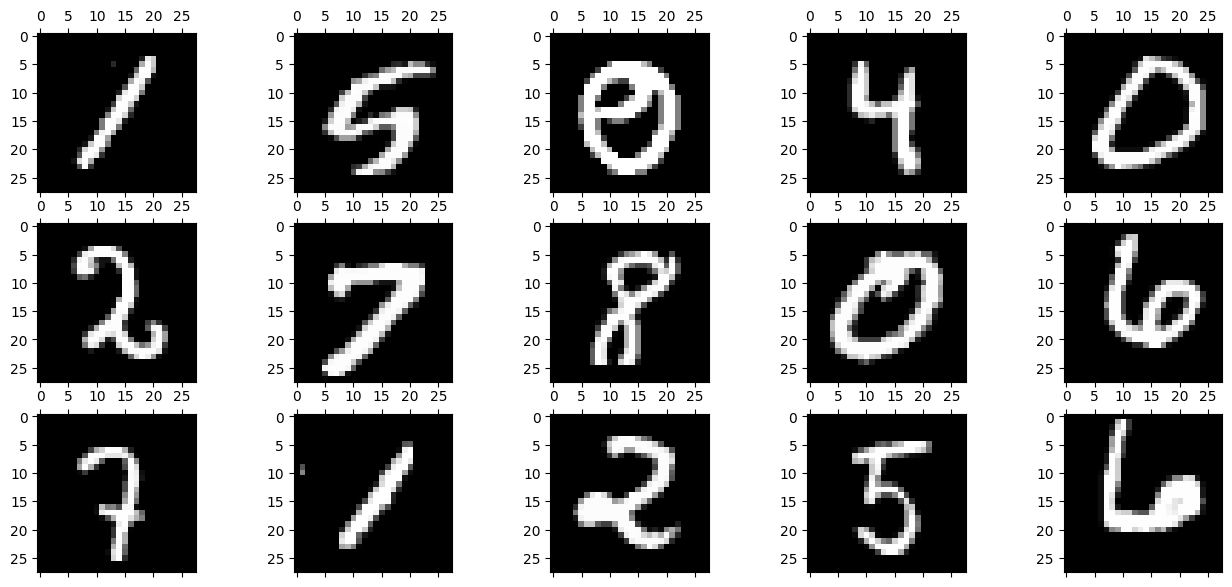

In [16]:
# 데이터 형태 시각화

import matplotlib.pyplot as plt

rndperm = np.random.permutation(df_train.shape[0])

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    ax.matshow(df_train.loc[rndperm[i], feat_cols].values.reshape((28,28)).astype(float))
plt.show()

In [17]:
# 학습 데이터 준비

import numpy as np

X_train = train_data.data.reshape(60000,-1).numpy()
y_train = train_data.targets.numpy()

X_test = test_data.data.reshape(10000,-1).numpy()
y_test = test_data.targets.numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [18]:
# KNN 학습 - Baseline

from sklearn.neighbors import KNeighborsClassifier
import time

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors= 5)
clf.fit(X_train, y_train)
print('Fit time : ', time.time() - start_time)

Fit time :  0.011953353881835938


In [19]:
from sklearn.metrics import accuracy_score

start_time = time.time()
pred = clf.predict(X_test)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Fit time :  47.71933102607727
0.9688


## 2. PCA & LDA 적용하기

In [30]:
# PCA 적용

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# PCA가 주성분을 찾을 때 각 특성의 스케일에 영향을 받기 때문에 표준화 진행
scaler = StandardScaler()
# 누적 설명 분산 비율이 95%가 되도록 주성분 개수를 선택
pca = Pipeline([('scaler', scaler), ('pca', PCA(n_components=0.95))])

# 훈련 데이터에 PCA 적용
X_train_pca = pca.fit_transform(df_train[feat_cols])
# 테스트 데이터에도 같은 PCA 변환을 적용
X_test_pca = pca.transform(df_test[feat_cols])

clf_pca = KNeighborsClassifier(n_neighbors= 5)
clf_pca.fit(X_train_pca, y_train)

KNeighborsClassifier()

In [31]:
# LDA 적용

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(df_train[feat_cols], y_train)

In [32]:
X_train_lda.shape

(60000, 9)

In [33]:
# 각 주성분이 전체 분산 중 얼마만큼을 설명하는지
lda.explained_variance_ratio_

array([0.2392286 , 0.20180995, 0.17849695, 0.10652571, 0.09406712,
       0.06906025, 0.04973746, 0.03429077, 0.0267832 ])

## 3. 결과 비교하기

In [34]:
# PCA 결과
start_time = time.time()
pred = clf_pca.predict(X_test_pca)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Fit time :  28.097615718841553
0.9486


In [35]:
# LDA 결과
start_time = time.time()
y_pred = lda.predict(X_test)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, y_pred))

Fit time :  0.06602072715759277
0.873


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


## 4. PCA & LDA 장단점 정리하기

####장단점을 자유롭게 적어주세요!

- PCA
  - 장점:
     1.   데이터의 상관성을 보존하며, 데이터의 변동성을 최대화하는데 초점을 맞추어 다목적으로 사용 가능하다.
     2.   주로 차원 축소에 활용되며, 비선형 데이터에도 적용 가능한 유연성이 있다.

  - 단점:
     1. 주로 데이터의 전체적인 변동성을 보존하는데 초점을 맞추기 때문에 클래스 간의 구분이 중요한 경우 성능이 제한될 수 있다.

- LDA
  - 장점:
     1. 클래스 간 분산을 최대화하고 클래스 내 분산을 최소화하여 데이터를 투영하기 때문에 분류 작업에 유용하다. 즉, 차원 축소와 분류를 동시에 수행할 수 있다.
     2. 위의 결과로 확인할 수 있듯, PCA보다 훨씬 빠른 Fit-time을 가지고 있다.
  - 단점:
     1. 다변량 정규 분포 가정을 기반으로 하므로, 정규 분포를 따르지 않는 확률 변수에 대한 정확한 추정이 어려울 수 있다.
     2. 이론상으로 양적 변수에는 적용이 어려우며, 클래스 간 샘플 수가 불균형하거나 이상치가 있는 경우 PCA에 비해 성능에 부정적인 영향을 받는다.